## 목표
---
### 공통
1. **GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성**하였다.  
    -  오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.


2. **생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증**하였다.
    - gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.


3. 추가적인 **GAN 모델구조 혹은 학습과정 개선 아이디어**를 제안하고 이를 적용하였다.
    - 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

---
### 개인
1. 하이퍼 파라미터를 변경하며 학습변화 확인

2. 다른 GAN 사용해보기


## STEP 0. 라이브러리 불러오기
---

In [4]:
import imageio
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

## STEP 1. 작업환경 구성하기
---


In [5]:
from google.colab import drive
drive.mount("/content/drive")

cifat10_path = '/content/drive/MyDrive/COLAB_data/dcgan_newimage/cifar10'

Mounted at /content/drive


##STEP 2. 데이터셋 구성하기
---
CIFAR-10 데이터셋은 `tf.keras` 안에 있는 `datasets`에 포함되어 있으니 쉽게 불러와 사용합니다.

In [6]:
cifar10 = tf.keras.datasets.cifar10

이번엔 y값인 label이 필요없으니 삭제해 줍니다.

In [7]:
(train_x, _), (test_x, _) = cifar10.load_data()

#모양 확인
print(train_x.shape, test_x.shape)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


train 5만개, test 1만개의 데이터가

(32,32) 사이즈로 3채널(RGB)로 구성되어 있습니다.  

다양한 것을 시도해보기위해 10가지의 라벨을 다 쓰지 않고 dog와 automobile만 불러 빡세게 학습시켜봅니다. 

In [8]:
########### 필요 라벨만 추출하여 사용하기 #################
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [9]:
# 개와 차 라벨만 추출
train_x_dog, test_x_dog = load_data(5)
train_x_car, test_x_car = load_data(1)

In [10]:
print(train_x_dog.shape, test_x_dog.shape, train_x_car.shape, test_x_car.shape)

(5000, 32, 32, 3) (1000, 32, 32, 3) (5000, 32, 32, 3) (1000, 32, 32, 3)


In [11]:
train_x = np.concatenate((train_x_dog, train_x_car), axis = 0)
test_x = np.concatenate((test_x_dog, test_x_car), axis = 0)

test는 사용하지 않으니 학습량을 높이기 위해 test 이미지도 train에 합쳐줍니다.

In [12]:
train_x = np.concatenate((train_x, test_x), axis = 0)

**※참고 : axis는 고정이 아닌 데이터셋에 따라 유동적으로 변함. (= aixs 0이 무조건 행의미x)**

In [13]:
print(train_x.shape)

(12000, 32, 32, 3)


잘 합쳐진 것 같으니, 데이터 처리를 계속합니다.

In [11]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


이번 실습에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.

In [14]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
print('train_x.shape:', train_x.shape)

max pixel: 1.0
min pixel: -1.0
train_x.shape: (12000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

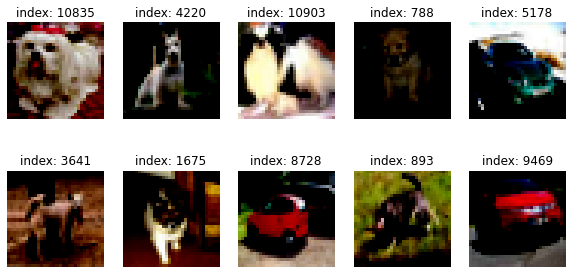

In [15]:
#한번 데이터를 꺼내서 어떻게 생겼는지 확인해 볼까요?
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 12000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

개와 차가 섞여서 나오는 것을 알 수 있습니다.  
이제 모델에 넣기위해 섞은 후 적절하게 섞어줍니다.

In [16]:
BUFFER_SIZE = 12000 #전체 데이터 섞기 위함
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기
---
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.  

- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.   

- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.  


### **DCGAN의 구조적 특징**

논문의 저자들은 최적의 결과를 내기 위해, 5가지 방법을 적용했다.
1. max-pooling layer를 없애고, strided convolution이나 fractional-srided convolution을 사용하여 feature-map의 크기를 조절한다.

2. Batch normalization을 적용한다.

3. Fully connected hidden layer를 제거한다.

4. Generator의 출력단의 활성함수로 tanh함수를 사용하고, 나머지 layer는 ReLU를 사용

5. Discriminator의 활성함수로 LeakyReLU를 사용

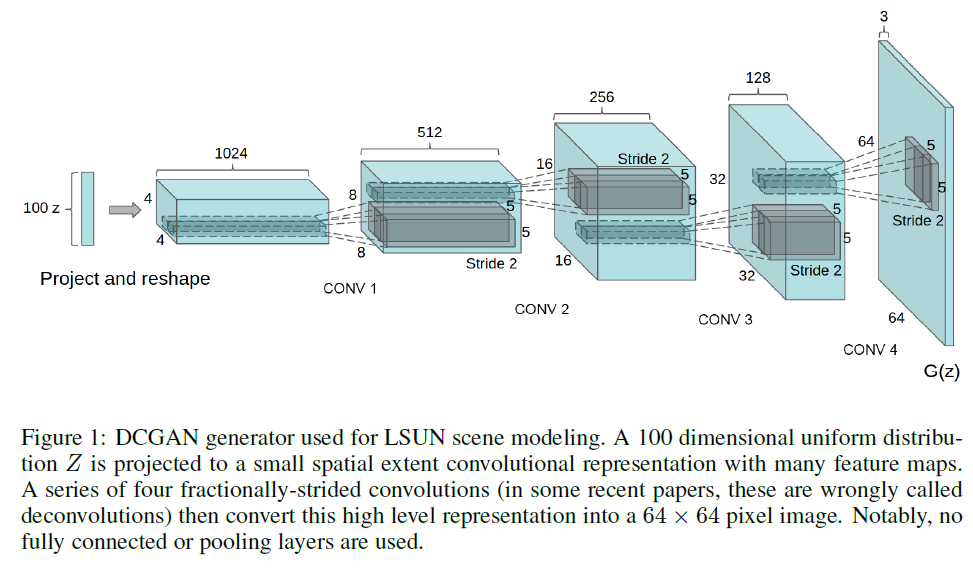

- 출처 :[블로그](https://psh7286.tistory.com/entry/DCGAN%EC%9C%BC%EB%A1%9C-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EB%8A%94-CIFAR-10)

In [17]:
################# 노이즈 설정 ####################
noise = tf.random.normal([1, 100])

In [16]:
################## generator model ###########
def make_generator_model():
    
    #시작
    model = tf.keras.Sequential()
    
    #첫번째 : Dense 층(12544개의 노드를 가짐)
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #두번째 : Reshape 층
    model.add(layers.Reshape((8, 8, 256)))
#   assert model.output_shape == (None_batch_size, 7, 7, 256_filter차원수) # 주목: 배치사이즈는 None이 주어집니다.

    
    #세번째 : Conv2DTranspose 층
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #네번째 : Conv2DTranspose 층
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #다섯번째 : Conv2DTranspoese층
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    
    return model
    

여기에서 가장 중요한 레이어는 바로 `Conv2DTranspose` 레이어입니다. **`Conv2DTranspose` 층은 일반적인 `Conv2D`와 반대로 이미지 사이즈를 넓혀주는 층** 입니다.   

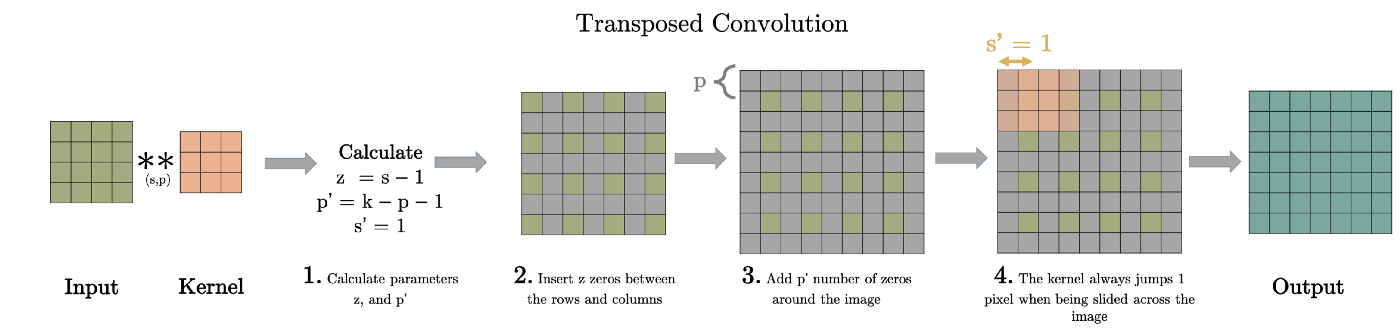

**Transpoed convolution과 deconvolution은 다름**
- Deconvonutional layer는 일반적인 convolutional layer의 반대버전으로
예를 들어 일반적인 convolutional layer를 거쳐 맏들어진 output이 deconvolve된다면
원본 input으로 되돌릴수 있다.

- transposed convolutional layer는 만들어내는 어떤 공간적인 차원이 같다는점에서 deconvolutional이랑 비슷하다. 하지만 Transposed convoluton은 일반적인 convolutional를 값은 되돌리지 못하고(원본 input과 달라지고) 차원만 되돌려 줄 뿐임.


#### 참고 : Leaky ReLU

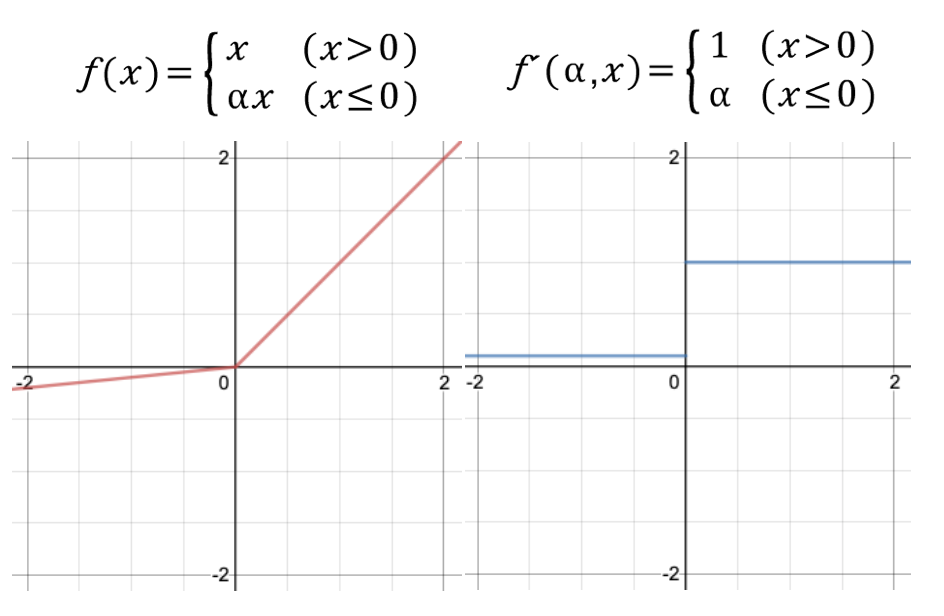
특징: ReLU와 거의 비슷한 형태를 갖는다. 입력 값이 음수일 때 완만한 선형 함수를 그려줍니다. 일반적으로 알파를 0.01로 설정함. (위 그래프에서는 시각화 편의상 알파를 0.1로 설정)
- [활성화 함수 특징](https://yeomko.tistory.com/39)

이제 생성모델을 `generator`라는 변수로 생성하고, 모델 세부 내용인 `summary`를 출력해본다.

In [17]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

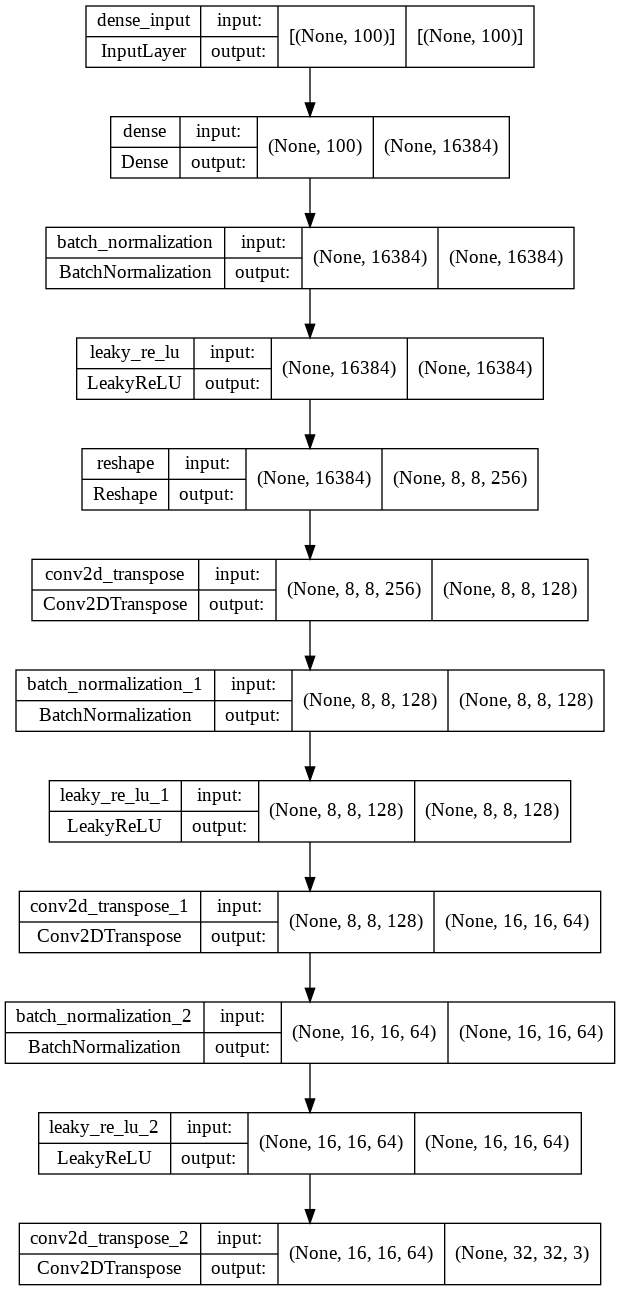

In [18]:
tf.keras.utils.plot_model(generator, 'generator1.png', show_shapes = True)

이 모델(generator1)에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 128) → (16, 16, 64) → (32, 32, 3)
순으로 이미지를 키워나가고, 최종 사이즈는 (32, 32, 3)로 준비했던 데이터셋과 형상이 동일하다.

- [참고 블로그](https://zzcojoa.tistory.com/89)


In [19]:
################ 이미지 하나 불러보기 ################
generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 32, 32, 3])

(32,32,3)으로 잘 나오네요! 이미지를 꺼내봅시다

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


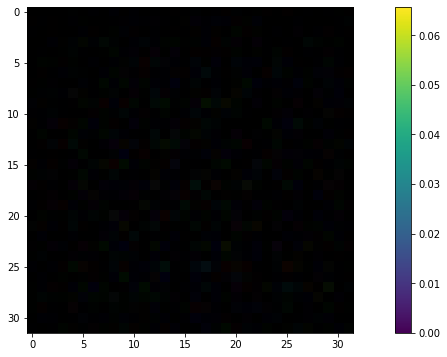

In [46]:
plt.imshow(generated_image[0, :, :, :])
plt.colorbar()
plt.show()

-1 ~ 1 내의 값이 잘 나오는 것을 알 수 있다. 하지만 아직 노이즈 값이기 떄문에 별 의미가 없네요!   

## STEP 4. 판별자 모델 구현하기
---
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
-Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다. 첫 번째 Conv2D 층에서 입력된 [32,32,3] 사이즈의 이미지는 다음 층을 거치며 (32,32,3) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 됩니다.
- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.



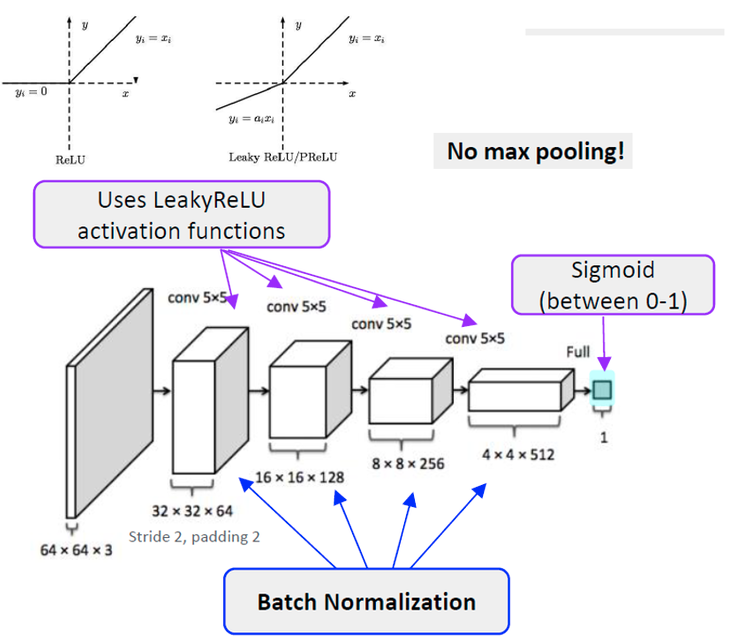

- 상기 모델에선 64*64의 input을 넣지만, 우린 32*32를 넣어준다. 

In [21]:
############ 판별자 모델 ##################
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    
    # 첫번째 층 : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #두번째 층 : conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #세번째 층: Flatten Layer
    model.add(layers.Flatten())
    
    #네번째 층 : Dense Layer -> 1차원으로 만들어서 출력
    model.add(layers.Dense(1))
    
    return model
    

In [22]:
discriminator = make_discriminator_model()

discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

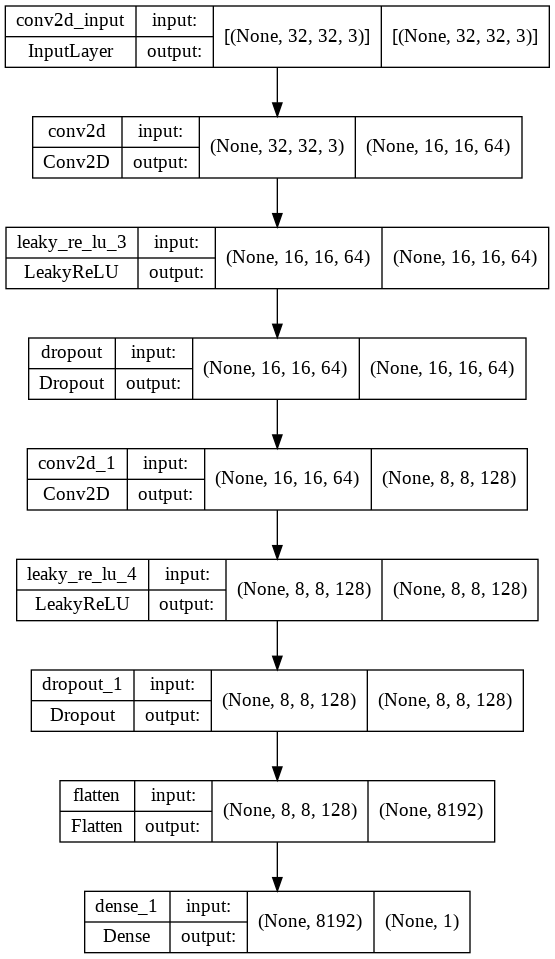

In [23]:
tf.keras.utils.plot_model(discriminator, 'discriminator1.png', show_shapes = True)

In [24]:
# 아까 생성한 노이즈 이미지 판별자에 입력시켜보기

decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00045533]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기
---
- GAN의 손실함수 수식  
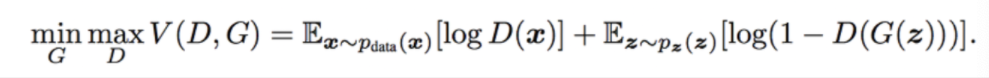
- E(x−Pdata(x))
​
 [logD(x)]: 실제 이미지의 데이터 분포(P 
data
​
 (x))에서 하나를 샘플링(x)하여 판별자에 넣었을 때 나온 값의 로그값의 기댓값
E 
z−P 
z
​
 (z)
​
 [log(1−D(G(z)))]: noise 벡터 분포(P 
z
​
 (z))에서 하나를 샘플링(z)하여 만든 생성이미지(G(z))를 판별자에 넣었을 때 나온 값의 로그값의 기댓값

- 생성자 : 생성자G 입장에서는 D가 G(z)를 1로 판별하게 만들고싶으므로 우변을 최소화하는 방향으로 학습하게 된다.  

- 판별자 :판별자D 입장에서는 x는 진짜(1)로 판별하고 z는 가짜(0)로 판별하여야 하므로 우변을 최대화하는 방향으로 학습하게 된다.


- GAN의 Global Optimum point는 G가 고정되어 있을 때 D∗G(x) = Pdata(x)/Pdata(x)+Pg(x)이며 Pg=P data 인데 이 두 조건이 만족할 때 D(G(z))는 1/2로 수렴한다. 
- [자세한 증명 과정 link](https://www.youtube.com/watch?v=AVvlDmhHgC4&t=1777s)


### STEP 5-1. 손실함수(loss)구현

교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없다.   
즉, **판별자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있다**.

그런데 `tf.keras.losses의 BinaryCrossEntropy` 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정한다. 따라서 `from_logits`를 `True`로 설정해 주어야 `BinaryCrossEntropy`에 입력된 값을 함수 내부에서 `sigmoid` 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다고 한다.

In [22]:
################ Cross Entropy 값 설정 ################
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.

- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

이를 각각 1, 0에 비교하기 위해 `tf.ones_like()`와 `tf.zeros_like()` 함수를 활용하여 그 차이를 loss로 설정한다.

In [23]:
########## 생성자 loss 함수 ############
def generator_loss(fake_output):
    # 생성자는 Fake가 1에 가까워야하니 1과 비교
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
############# 판단자 loss 함수 ############
def discriminator_loss(real_output, fake_output):
    # 판단자는 real은 1에 가까워야하고
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # fake는 0에 가까워야함
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # total은 두갤 합쳐줌
    total_loss = real_loss + fake_loss
    
    return total_loss

### STEP 5-2. 정확도 및 최적화 함수 구현
---
- 정확도 
    - 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다.   
    -  **판별자와 생성자는 Max-Min 관계**이므로 서로 0.5에 수렴하는 것이 가장 이상적이다. 따라서 real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적임.

- 최적화 함수
    - 기존 논문 및 가장 평균적으로 사용하는 Adam을 사용하고, learning rate도 

In [25]:
################ 판단자 accuracy 함수 ###################
def discriminator_accuracy(real_output, fake_output):
    #reduce_mean 으로 ()안의 결과를 평균내어 정확도를 계산한다. 
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))

    return real_accuracy, fake_accuracy

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
######### 학습 저장용 샘플 #########
noise_dim = 100
num_examples_to_generate = 16

#같은 노이즈로 비교하기 위해 100차원 노이즈 seed를 저장함
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기
---
1. 먼저 1개의 미니배치를 수행하는 train_step()함수를 구현한다.
2. 16개의 고정 seed를 입력하여 훈련과정 중 생기는 변화를 시각화한다.
3. 훈련 epoch 별 생성자/판단자의 loss와 판별자의 real/fake 구분 accuracy의 history를 그래프로 시각화한다.
4. 혹시모를 비상사태를 위해 `training_checkpoints` 디렉토리에 몇 epoch마다 모델을 저장하는 `checkpoint` 모듈을 설정한다.

In [54]:
################# 1개의 미니배치를 수행하는 함수 #################
@tf.function

# (1) 입력데이터
def train_step(images):
    #(2) 생성자 입력 노이즈
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    #(3) tf.GradientTape() 오픈
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #(4) generated_images 생성
        generated_images = generator(noise, training=True)
    
        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    #(10) 리턴값
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [29]:
########### 이미지 추출 및 저장 ##############

def generate_and_save_images(model, epoch, it, sample_seeds):
    # 확인용이기 때문에 training은 False로 변경
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]): 
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('{}/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(cifat10_path, epoch, it))

    plt.show()

In [30]:
############# loss 및 accuracy history 저장 ##############

rcParams['figure.figsize'] = 15, 6 

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/training_history/train_history{:04d}.png'
                    .format(cifat10_path, epoch))
    plt.show()

In [31]:
############## 모델 저장 Check Point 생성 ####################
checkpoint_dir = cifat10_path + '/training_checkpoints'


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기
---

- 생성자는 학습을 통해 원본데이터의 분포로 수렴하게 되고, 점점 진짜와 같은 이미지를 뽑아낼 수 있다. 
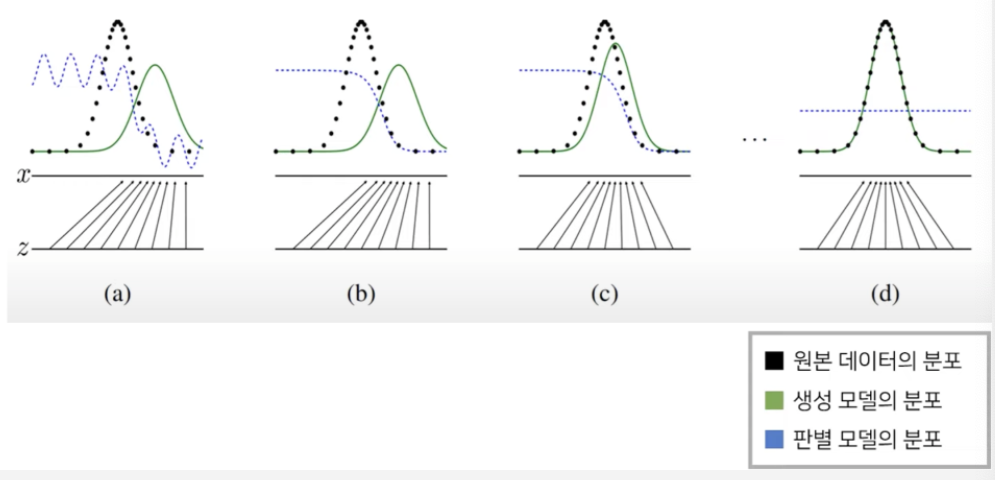

- Epoch를 진행하고 생성된 이미지 gif 파일로 만들어 시각화 한다.

**※참고**  
- 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생긴다. 그때 checkpoint 모듈을 이용해 저장한 모델을 불러와 바로 진행할 수 있다.

In [32]:
############## 학습 모델 #################
def train(dataset, epochs, save_every):
    #시작시간 저장 및 히스토리 생성
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    #에포크돌리기
    for epoch in range(epochs):
        epoch_start = time.time()
        #배치별 데이터 셋을 입력하고 iterator 
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

우선 300epoch로 돌려봅니다.

In [51]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

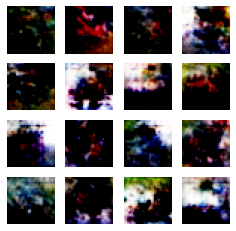

Time for training : 1448 sec


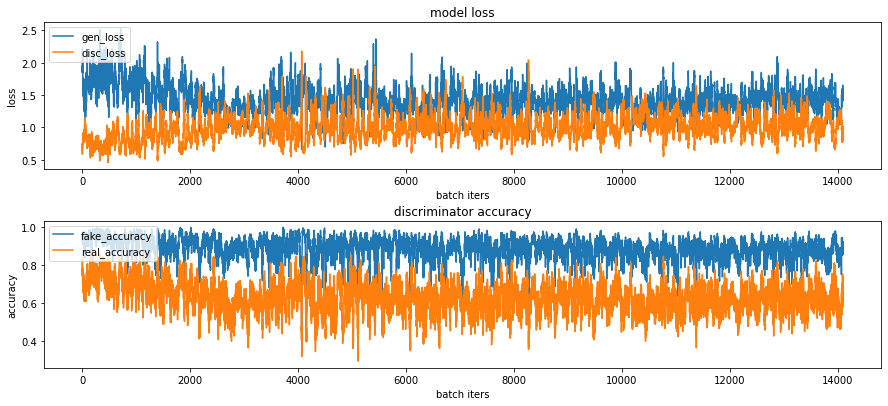

CPU times: user 24min 27s, sys: 30 s, total: 24min 57s
Wall time: 24min 9s


In [52]:
%%time
train(train_dataset, EPOCHS, save_every)


별... 성과가 없네요.... checkpoint에서 불러와서 300회 추가해봅니다.

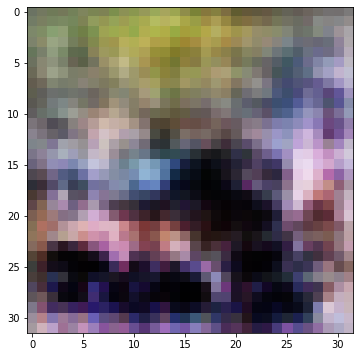

In [53]:
############## Check Point 로드 함수 #################
checkpoint_dir = cifat10_path + '/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

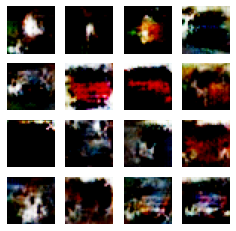

Time for training : 1445 sec


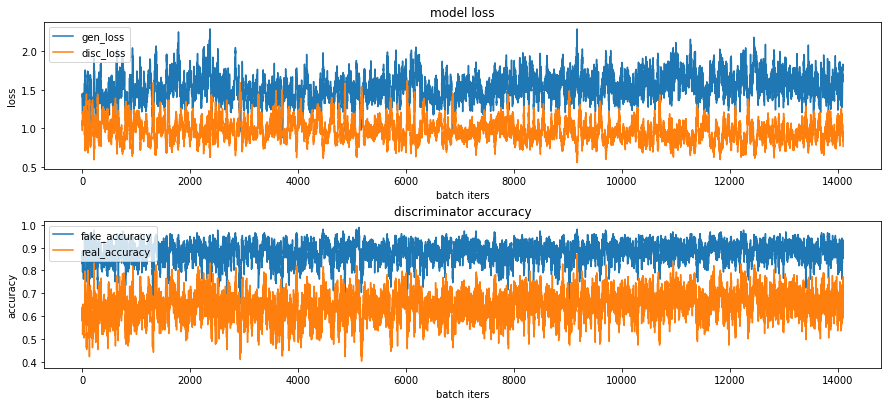

CPU times: user 24min 22s, sys: 31.1 s, total: 24min 53s
Wall time: 24min 6s


In [54]:
%%time
train(train_dataset, EPOCHS, save_every)

In [55]:
################# 학습 결과 gif 파일화 하기 ############################
anim_file = cifat10_path + '/CIFAR2_test_image_1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(cifat10_path + '/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


- 첫 300 epoch 진행 후 모습  

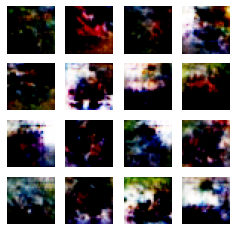  

- 300 epoch 추가 학습 후 모습 (총 600epoch)  

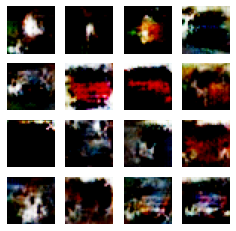

- 첫 300 epoch 진행 후 loss & accuracy  
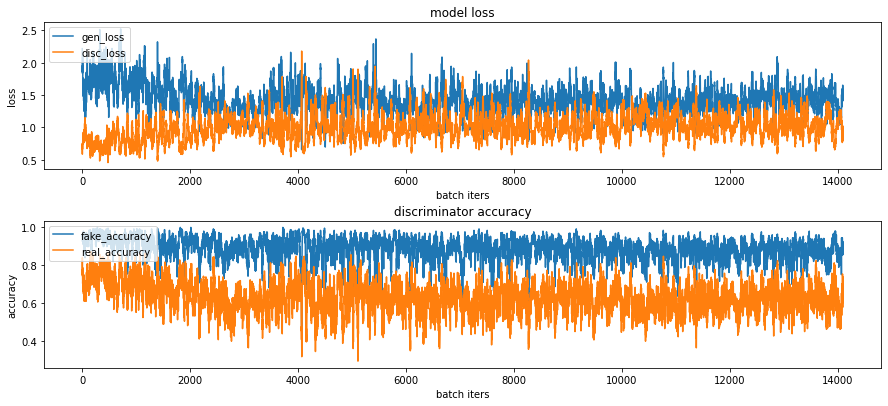  

- 추가 300 epoch 진행한 후 loss & accuracy   
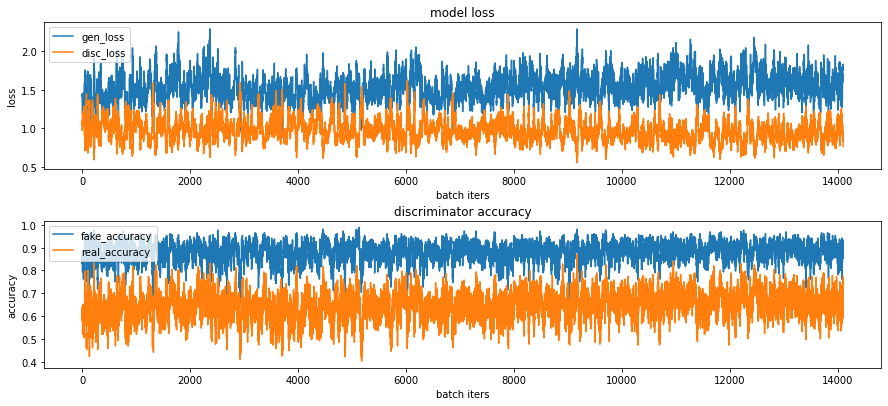

### 1번. 바닐라모델의 결과
- 사진에선 유의미한 변화를 느끼지 못했다. 
- loss & accuracy에선 첫 300 epoch 진행시 첫 3000iterate 에서는 loss와 accuracy 모두 감소하였으나, 이후로는 비슷하게 유지되는 것이 보였다. 
- 바닐라 모델이기에 별다른 기대는 하지 않았다..ㅎ... 
- 이후 진행을 어떻게 할 것인가. 지금 바꿀 수 있는 파라미터로는   
    - optimizer : 종류(현 Adam, learning rate)
    - Generator : layer 수, layer 파라미터, layer 종류
    - Discriminator : layer 수, layer 파라미터, layer 종류
    - loss : Cross Entropy 파라미터  
    등이 있는 것 같다. 

이후 진행에선 우선 간단하게 **같은 데이터로 epochs는 600으로 고정**하고,   
    1) image size(32, 32)에 비해 generator와 discriminaor의 **kernel size**(5, 5)가 지금 갖고 있는  큰 것 같아 낮춰주고,   
    2) **stribes**도 현 (2,2) 에서 낮춰**image를 더 집중해서 볼 수 있도록** 하려고한다. 

**※참고**  
- Conv2DTranspose layer는 

In [36]:
############ 판별자 모델 ##################
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    
    # 첫번째 층 : Conv2D layer
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #두번째 층 : conv2D layer
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #세번째 층: Flatten Layer
    model.add(layers.Flatten())
    
    #네번째 층 : Dense Layer -> 1차원으로 만들어서 출력
    model.add(layers.Dense(1))
    
    return model

In [51]:
################## generator model ###########
def make_generator_model():
    
    #시작
    model = tf.keras.Sequential()
    
    #첫번째 : Dense 층(12544개의 노드를 가짐)
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #두번째 : Reshape 층
    model.add(layers.Reshape((8, 8, 256)))
#   assert model.output_shape == (None_batch_size, 7, 7, 256_filter차원수) # 주목: 배치사이즈는 None이 주어집니다.

    
    #세번째 : Conv2DTranspose 층
    model.add(layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #네번째 : Conv2DTranspose 층
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #다섯번째 : Conv2DTranspoese층
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    
    return model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_15 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 8, 8, 128)        131072    
 Transpose)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 8, 8, 128)       

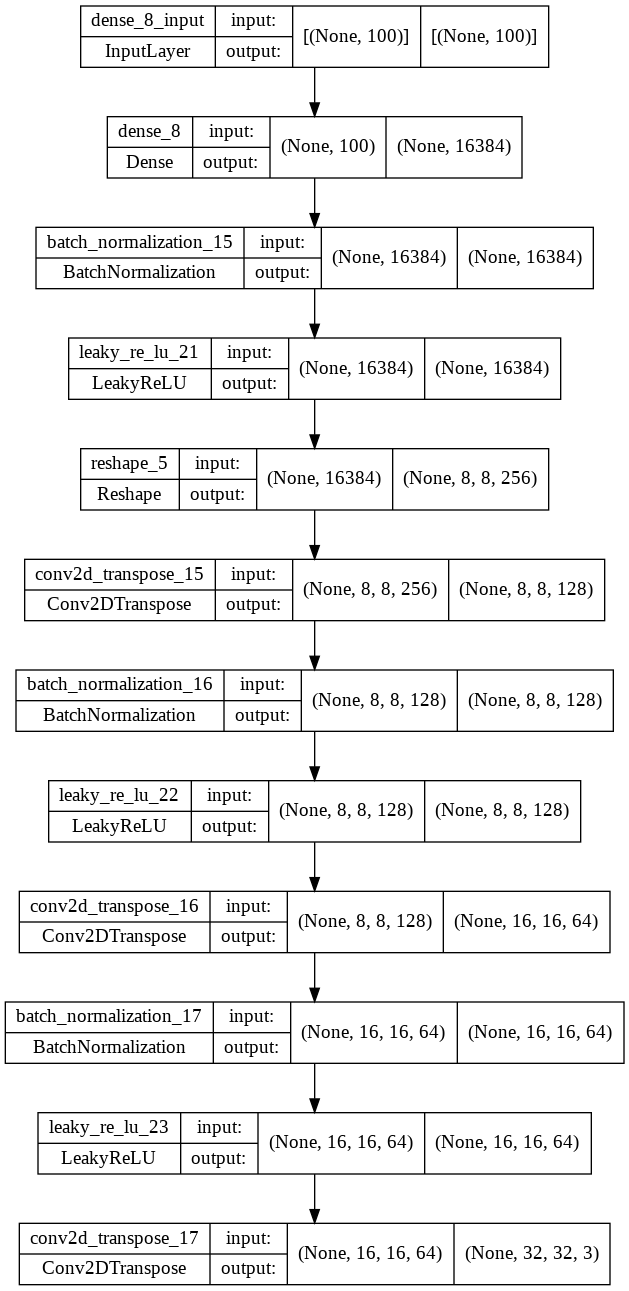

In [52]:
generator = make_generator_model()

generator.summary()

tf.keras.utils.plot_model(generator, 'generator2.png', show_shapes = True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 131072)           

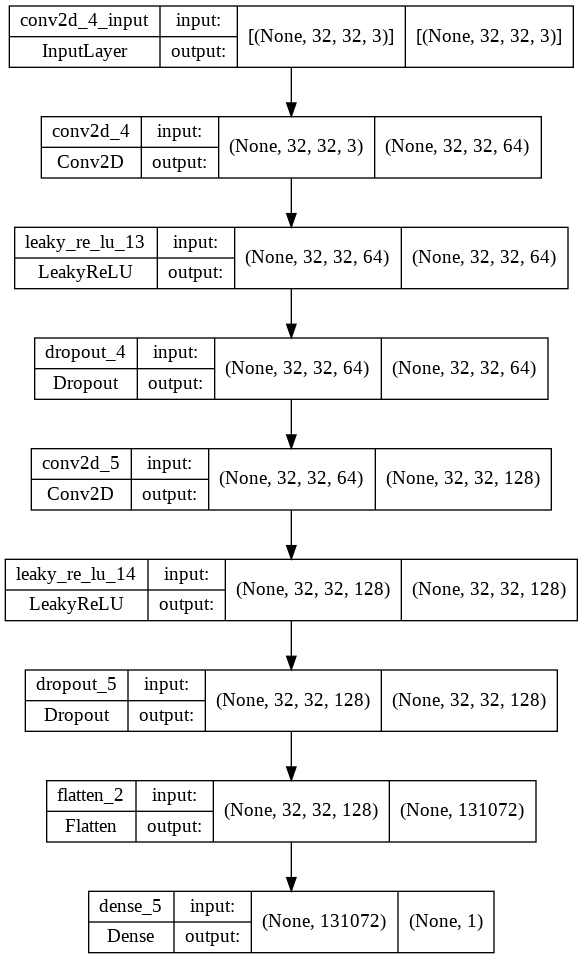

In [44]:
discriminator = make_discriminator_model()

discriminator.summary()

tf.keras.utils.plot_model(discriminator, 'discriminator2.png', show_shapes = True)

In [45]:
save_every = 15
EPOCHS = 600

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

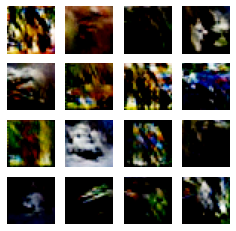

Epoch 519 | iter 1
Time for epoch 519 : 0 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

살펴보니 

[VAE-GAN Explained!](https://www.youtube.com/watch?v=yyqfZfnSzcw)  
[VAE-GAN tensorflow example git](https://github.com/zhangqianhui/vae-gan-tensorflow)  

[VAE & GAN 간단 비교](https://dev-hani.tistory.com/entry/Symbolic-Music-Genre-Transfer-with-CycleGAN)

https://jaejunyoo.blogspot.com/2017/04/auto-encoding-variational-bayes-vae-1.html


[GAN 오토인코더와 GAN을 사용한 표현 학습과 생성적 학습](https://ireland-ireland.tistory.com/entry/GAN-%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94%EC%99%80-GAN%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%9C-%ED%91%9C%ED%98%84-%ED%95%99%EC%8A%B5%EA%B3%BC-%EC%83%9D%EC%84%B1%EC%A0%81-%ED%95%99%EC%8A%B5)


핸즈온 머신러닝 관련 https://kdeon.tistory.com/55
